# TP2 - Detector de Máximo Enfoque





30 fotogramas por segundo, video de 5 segundos --> 150 frames

In [2]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
def mostrar_imagen(imagen, titulo=''):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv.cvtColor(imagen, cv.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

### 1. Implementación del algoritmo que calcula la métrica propuesta

Se implementa el algoritmo que calcula la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ (Kanjar De and V. Masilamani (2013), Procedia Engineering 64 p149–158).

Tal como se explica en el paper, esta métrica está relacionada con la cantidad de componentes de alta frecuencia en la imagen. Cuanta mayor sea el número de componentes de alta frecuencia en la imagen, mejor será la calidad de la imagen (tendrá menor desenfoque o *blurring*).

El algoritmo consiste en los siguientes pasos:

**Algoritmo para Métrica de Calidad de Imagen *(Image Quality Measure)***
- Input: Imagen I de tamaño M×N.
- Output: Image Quality measure (FM), donde FM es la Frequency Domain Image Blur Measure (medida de desenfoque en el dominio de la frecuencia)
- Paso 1: Computar F, que es la Transformada de Fourier de la imagen I.
- Paso 2: Encontrar Fc, obtenida haciendo el shift del origen de F al centro.
- Paso 3: Calcular AF = abs (Fc), donde AF es el valor absoluto de la transformada de Fourier centrada de I.
- Paso 4: Calcular M = max (AF), donde M es el valor máximo de la frecuencia en F.
- Paso 5: Calcular TH = cantidad total de pixels de F donde el valor de pixel > umbral, siendo el umbral = M/1000.
- Paso 6: Calcular Image Quality measure (FM) como:
- *Image Quality Measure (FM) = Th / (M x N)*

In [ ]:
def ImageQualityMeasure(image):
    """
    Calcula la medida de calidad de imagen según el algoritmo propuesto en el paper "Image
    Sharpness Measure for Blurred Images in Frequency Domain“.
    Args:
        image (numpy.ndarray): Imagen de entrada en formato BGR.
    Returns:
        FM (float): Valor de la medida de calidad de imagen (Frequency Domain Image Blur Measure).
    """
    # Paso 1: Computar F, que es la Transformada de Fourier de la imagen I.
    img_fft=np.fft.fft2(image)

    # Paso 2: Encontrar Fc, obtenida haciendo el shift del origen de F al centro.
    img_fft=np.fft.fftshift(img_fft)

    # Paso 3: Calcular AF = abs (Fc), donde AF es el valor absoluto de la transformada de Fourier centrada de I.
    AF = np.abs(img_fft)

    # Paso 4: Calcular M = max (AF), donde M es el valor máximo de la frecuencia en F.
    M = np.max(AF)

    # Paso 5: Calcular TH = cantidad total de pixels de F donde el valor de pixel > umbral, siendo el umbral = M/1000.
    thres = M / 1000
    TH = np.sum(AF > thres)
    
    # Paso 6: Calcular Image Quality measure (FM) como: FM = Th / (M x N)*
    M, N = image.shape[:2]
    FM = TH / (M * N)

    return FM

### 1.1 Medición sobre todo el frame

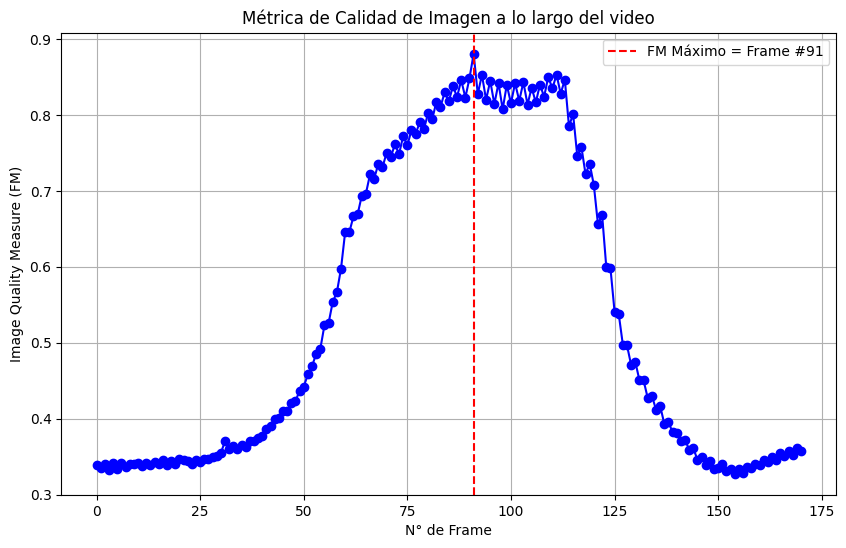

In [29]:
# Abre el video
video_path = 'videos/focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    num_frames = int(captura_video.get(cv.CAP_PROP_FRAME_COUNT))
    FM = []
    for i in range(num_frames):
        ret, frame = captura_video.read()
        if ret:
            FM.append(ImageQualityMeasure(frame))
        else:
            break

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

# Calcula el frame con máximo valor de FM
max_FM = np.max(FM)
max_frame_index = np.argmax(FM)

# Muestra los resultados
plt.figure(figsize=(10, 6))
plt.plot(FM, marker='o', color='b')
plt.axvline(x=max_frame_index, color='r', linestyle='--', label=f'FM Máximo = Frame #{max_frame_index}')
plt.title('Métrica de Calidad de Imagen a lo largo del video')
plt.xlabel('N° de Frame')
plt.ylabel('Image Quality Measure (FM)')
plt.grid()
plt.legend()
plt.show()

Mostrar el frame con el máximo enfoque:

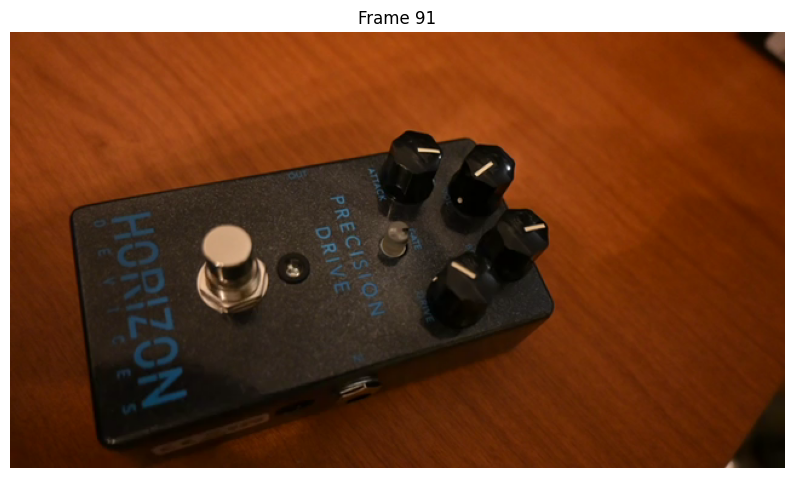

In [31]:
# Abre el video
video_path = 'videos/focus_video.mov'
captura_video = cv.VideoCapture(video_path)

# Define el número de frame a leer
n_frame = max_frame_index

# Verifica si el video se abrió correctamente
if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Llevar el video al frame deseado y leerlo
    captura_video.set(cv.CAP_PROP_POS_FRAMES, n_frame)
    ret, frame = captura_video.read()
    if ret:
        mostrar_imagen(frame, titulo=f'Frame {n_frame}')

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

### 1.2 Medición sobre una ROI ubicada en el centro del frame. 

Área de la ROI = 5 o 10% del área total del frame.

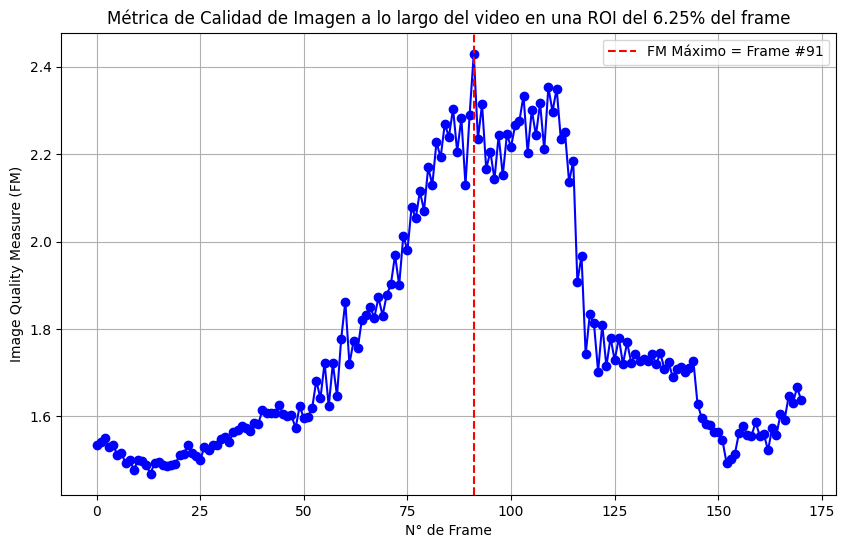

In [54]:
# Abre el video
video_path = 'videos/focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtener una ROI del video con un área del 5% del frame

    # Obtiene el tamaño del frame
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    # Define el tamaño de la ROI (5% del área total)
    roi_width = int(frame_width * 0.25)
    roi_height = int(frame_height * 0.25)
    
    # Calcula las coordenadas de la ROI centrada
    x_start = (frame_width - roi_width) // 2
    y_start = (frame_height - roi_height) // 2
    
    num_frames = int(captura_video.get(cv.CAP_PROP_FRAME_COUNT))
    FM = []
    for i in range(num_frames):
        ret, frame = captura_video.read()
        if ret:
            # Extraer la ROI del frame actual y calcular métrica
            roi_frame = frame[y_start:y_start + roi_height, x_start:x_start + roi_width]
            FM.append(ImageQualityMeasure(roi_frame))
        else:
            break

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

# Calcula el frame con máximo valor de FM
max_FM = np.max(FM)
max_frame_index = np.argmax(FM)

# Área de la imagen con respecto al frame original
area=(roi_width*roi_height) / (frame_width*frame_height) * 100

# Muestra los resultados
plt.figure(figsize=(10, 6))
plt.plot(FM, marker='o', color='b')
plt.axvline(x=max_frame_index, color='r', linestyle='--', label=f'FM Máximo = Frame #{max_frame_index}')
plt.title(f'Métrica de Calidad de Imagen a lo largo del video en una ROI del {area:.2f}% del frame')
plt.xlabel('N° de Frame')
plt.ylabel('Image Quality Measure (FM)')
plt.grid()
plt.legend()
plt.show()

Mostrar el frame con el máximo enfoque en la ROI:

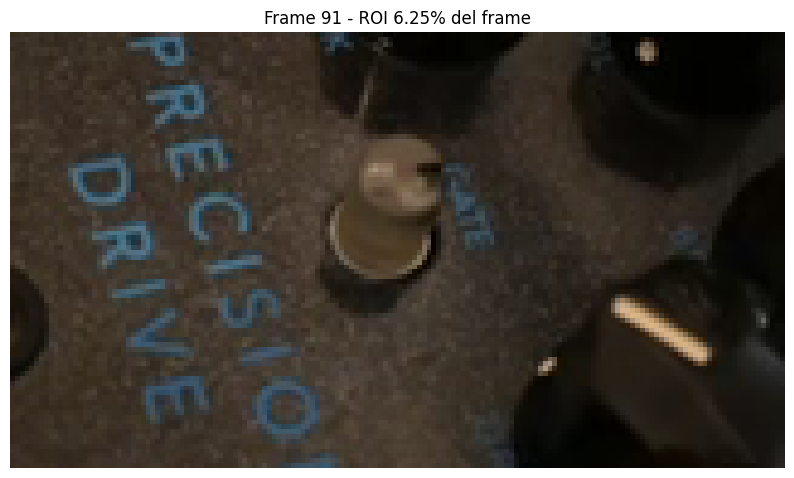

In [55]:
# Abre el video
video_path = 'videos/focus_video.mov'
captura_video = cv.VideoCapture(video_path)

# Define el número de frame a leer
n_frame = max_frame_index

# Verifica si el video se abrió correctamente
if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Llevar el video al frame deseado y leerlo
    captura_video.set(cv.CAP_PROP_POS_FRAMES, n_frame)
    ret, frame = captura_video.read()
    roi_frame = frame[y_start:y_start + roi_height, x_start:x_start + roi_width]
    if ret:
        mostrar_imagen(roi_frame, titulo=f'Frame {n_frame} - ROI {area:.2f}% del frame')

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

En ambos experimentos se obtiene el máximo enfoque en el mismo frame (Frame #91). A partir de estos resultados, se observa que analizando una ROI con un área del 6.25% del frame original es posible alcanzar el mismo resultado que analizando el frame completo. 